# A workflow for analyzing Craigslist Text using LDA

In [2]:
"""Import Modules"""
import preprocess
from datetime import datetime
import lda_output
import pandas as pd
import numpy as np
import logging
import cl_census
from gensim import corpora, models, similarities, matutils

In [3]:
"""Start Logging"""
# Some of the code below takes a long time to run, the logging helps knwo that it's still working
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [4]:
"""Import text as DataFrame"""
# this is a preprocessed file of around 40,000 CL texts
data_path = 'data/processed4_22.csv'
df = pd.read_csv(data_path, index_col=0,dtype = {'GEOID10':object,'blockid':object})


In [5]:
"""Make New Demo Columns"""
# this is based on the census vars I downloaded
prop_list = ['white','black','aindian','asian','pacisland','other','latinx']
df['poverty_proportion'] = df.under_poverty/df.total_poverty
# making census vars into proportions
for proportion in prop_list:
    df[proportion+'_proportion'] = df[proportion]/df.total_RE

In [15]:
"""Make Stratifying Columns"""
strat_list = []
new_col_list = []
# make a list of new col names
for proportion in prop_list:
    strat_list.append(proportion+'_proportion')
    new_col_list.append('high_'+proportion)
#make some stratifing columns
df = preprocess.make_stratifier(df, 'income', 'high_income')
df = preprocess.make_stratifier(df, 'poverty_proportion', 'high_poverty')
df = preprocess.make_stratifier(df, strat_list, new_col_list)


In [7]:
"""Make Categorical Race_Income Variable"""
#starts as high_white
df['race_income'] = df.high_white
#adjust to include income
df = df.assign(race_income =  np.where(df.high_income==1, df.race_income+2, df.race_income))
#add text lables 
labels = {3:"high income and high white", 2:"high income low white", 1:"low income high white", 0:"low income low white"}
df['race_income_label'] = [labels[x] for x in df.race_income]
df[['race_income', 'race_income_label']]
#check to make sure it worked
pd.crosstab(df.race_income_label, [df.high_income, df.high_white])

high_income                    0           1      
high_white                     0     1     0     1
race_income_label                                 
high income and high white     0     0     0  5857
high income low white          0     0  3920     0
low income high white          0  3894     0     0
low income low white        6579     0     0     0

# Model And Output
From here, we'll work through making a corpus and dictionary, fitting an LDA model, interpreting the results various ways, and then outuptting some info in a readable format. I'd love feedback on this part of the workflow especially :).

Also, it talkes a long time to fit an LDA model, but if you pulled my GIT, you should have some saved models in the models folder. I've commented out the lines that run the model below and commented *in* the lines which load a model that's already been fit to the data loaded above.

*the cell below takes some time to run*

In [8]:
"""Make Corpus and Dictionary"""
with open('resources/hoods.txt') as f:
    neighborhoods = f.read().splitlines()
from sklearn.feature_extraction import stop_words
hood_stopwords = neighborhoods + list(stop_words.ENGLISH_STOP_WORDS)
corpus, dictionary = preprocess.df_to_corpus([str(x) for x in df.clean_text], stopwords=hood_stopwords)

2018-04-26 17:45:55,815 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-26 17:45:57,041 : INFO : adding document #10000 to Dictionary(28823 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...)
2018-04-26 17:45:58,335 : INFO : adding document #20000 to Dictionary(60926 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...)
2018-04-26 17:45:58,374 : INFO : built Dictionary(61885 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...) from 20250 documents (total 2689227 corpus positions)


In [9]:
"""Run Lda Model"""
n_topics = 50
n_passes = 50
# Run this if you have access to more than one core set workers=n_cores-1 
# this takes more than an hour on my mac, so if you just wnat to mess around, load the model in the cell below
#model = models.ldamulticore.LdaMulticore(corpus, id2word = dictionary, num_topics=n_topics, passes = n_passes, iterations = 100, minimum_probability=0, workers=3)
# otherwise run this
#model = models.LdaModel(corpus, id2word = dictionary, num_topics=n_topics, passes = n_passes, iterations = 100, minimum_probability=0)
# save the model for future use
#now = datetime.now()
#model.save('models/model'+str(now.month)+'_'+str(now.day))


In [10]:
"""Load an Premade Model"""
model = models.LdaModel.load('models/model4_23')

2018-04-26 17:46:00,569 : INFO : loading LdaModel object from models/model4_23
2018-04-26 17:46:00,626 : INFO : loading expElogbeta from models/model4_23.expElogbeta.npy with mmap=None
2018-04-26 17:46:00,746 : INFO : setting ignored attribute dispatcher to None
2018-04-26 17:46:00,748 : INFO : setting ignored attribute id2word to None
2018-04-26 17:46:00,750 : INFO : setting ignored attribute state to None
2018-04-26 17:46:00,752 : INFO : loaded models/model4_23
2018-04-26 17:46:00,755 : INFO : loading LdaState object from models/model4_23.state
2018-04-26 17:46:00,927 : INFO : loaded models/model4_23.state


*the cell below takes some time to run*

In [11]:
"""Merge LDA output and DF"""
#Make LDA corpus of our Data
lda_corpus = model[corpus]
#make dense numpy array of the topic proportions for each document
doc_topic_matrix = matutils.corpus2dense(lda_corpus, num_terms=n_topics).transpose()
df = df.reset_index(drop=True).join(pd.DataFrame(doc_topic_matrix))

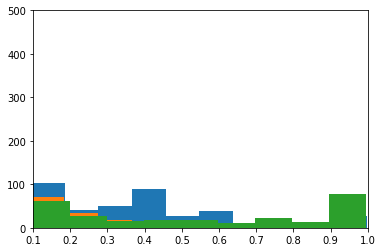

In [12]:
"""Look at the distributions of the different topics"""
#you can mess with this if you want to look at different topic histograms
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df[[26]].sort_values(by=26, ascending=False).head(400).values)
plt.hist(df.groupby('GEOID10').mean()[[4]].dropna().values)
df.columns
df.groupby('race_income_label').mean()[26]
plt.hist(df[df.race_income==0][41].values)
plt.axis([.1, 1, 0, 500])
weights = df[list(range(50))].mean()

# Using stratifiers to organize the LDA output
The next section here explores various ways to sort the data. Which of these seems most useful?

In [13]:
"""Use stratifier to create various comparisions of topic distributions"""
#strat_col = 'high_income'
# sorted_values = lda_output.compare_topics_distribution(df, n_topics, strat_col)
# Uncomment one of these to sort the Text output differently
#sorted_values = lda_output.summarize_on_stratifier(df, n_topics, strat_col)
#sorted_values = mean_diff.sort_values('difference', ascending=False)

'Use stratifier to create various comparisions of topic distributions'

In [37]:
"""Try a Multinomial LogisticRegression"""
df['clean_price'] = pd.to_numeric(df.price.str.replace(r'\D',''))
df['top_topic'] = df[list(range(50))].idxmax(1)
df['log_income'] = np.log(df.income)
df['log_price'] = np.log(df.clean_price)

from sklearn.linear_model import LogisticRegression

X = df.dropna()[['white_proportion', 'log_income', 'log_price']]
y = df.dropna().top_topic
y_highwhite = df.dropna().high_white
LR = LogisticRegression()
LR.fit(X,y)
# high_white_LR = LR.fit(X,y_highwhite)
# high_white_LR.score(X,y_highwhite)
# highwhite_coefs = pd.DataFrame(LR.coef_).rename(labels).transpose()
lr_coefs = pd.DataFrame(LR.coef_).rename({0:"white_proportion",1:"log_income",2:"log_price"}, axis=1).merge(
    lda_output.summarize_on_stratifier(
        df, n_topics, strat_col='high_white'), left_index=True, right_index=True)
sorted_values = lr_coefs.assign(abs_white = abs(lr_coefs.white_proportion))
sorted_values = sorted_values.sort_values('abs_white', ascending=False).drop(['topic','difference', 'proportion','abs_white'], axis=1)
sorted_values

,white_proportion,log_income,log_price,all_r,high_white,not_high_white
31,-3.866743,0.308744,-0.524838,0.090420,0.067890,0.111344
14,3.835316,0.087480,-1.468045,0.079951,0.079889,0.080008
49,-3.709143,-0.282753,0.003197,0.083802,0.065224,0.101057
25,3.412120,-0.595611,-0.067743,0.183802,0.228182,0.142585
4,-3.186431,0.088656,-0.952967,0.217877,0.164086,0.267835
29,-3.177407,-0.186778,-0.186558,0.049185,0.047175,0.051052
10,2.904119,-0.199481,0.102820,0.209383,0.260999,0.161444
41,-2.681789,-0.149053,-0.215992,0.064247,0.056199,0.071721
45,-2.647507,-0.214438,0.589736,0.063605,0.065942,0.061434
6,-2.547803,0.528780,-0.799996,0.097877,0.092708,0.102676


# Finally: Output
This final cell uses one version of the ordered topics from above to create organized output of the models, their distribution across our stratifier (race_income_labeled), and example texts

In [38]:
"""Produces useful output of topics and example texts"""
# decide how you want to sort the topics, I'm using the predicted probabilities from above
# Uncomment one of these to sort the Text output differently
#sorted_values = lda_output.summarize_on_stratifier(df, n_topics, strat_col)
#sorted_values = mean_diff.sort_values('difference', ascending=False)
#sorted_values = lr_coefs.sort_values('summed_diff', ascending=False)
#sorted_values = predicted_proba.sort_values('summed_diff', ascending=False)
now = datetime.now()
lda_output.text_output(df, 
                       text_col='body_text', 
                       filepath='output/cl'+str(now.month)+'_'+str(now.day)+'.txt', 
                       model= model, 
                       sorted_topics=sorted_values, 
                       strat_col='race_income_label', 
                       #set to False to save to file
                       print_it = True,
                       cl=True)


2018-04-26 18:03:58,533 : INFO : Automatically generating topic list
2018-04-26 18:03:58,547 : INFO : topic #0 (0.020): 0.024*"apartments" + 0.011*"bedroom" + 0.010*"floor" + 0.009*"apartment" + 0.008*"!" + 0.007*"enjoy" + 0.007*"available" + 0.007*"make" + 0.007*"living" + 0.006*"parking" + 0.006*"features" + 0.006*"modern" + 0.006*"wildreed" + 0.006*"kitchen" + 0.006*"amenities" + 0.006*"rooftop" + 0.006*"url" + 0.005*"high" + 0.005*"plans" + 0.005*"deck"
2018-04-26 18:03:58,551 : INFO : topic #1 (0.020): 0.092*"â" + 0.024*"contact" + 0.012*"url" + 0.011*"!" + 0.011*"infox" + 0.011*"$" + 0.007*"available" + 0.007*"availability" + 0.006*"lease" + 0.006*"wa" + 0.006*"fitness" + 0.006*"today" + 0.005*"access" + 0.005*"pool" + 0.005*"center" + 0.004*"resident" + 0.004*"date" + 0.004*"lounge" + 0.004*"movein" + 0.004*"outdoor"
2018-04-26 18:03:58,554 : INFO : topic #2 (0.020): 0.040*"green" + 0.032*"lake" + 0.013*"energy" + 0.012*"circa" + 0.011*"natural" + 0.010*"youll" + 0.010*"access" 

2018-04-26 18:03:58,620 : INFO : topic #22 (0.020): 0.012*"community" + 0.011*"ave" + 0.009*"th" + 0.008*"n" + 0.008*"anne" + 0.008*"queen" + 0.007*"access" + 0.007*"url" + 0.007*"center" + 0.007*"park" + 0.006*"pet" + 0.006*"street" + 0.006*"ne" + 0.006*"available" + 0.006*"storage" + 0.006*"bike" + 0.005*"parking" + 0.005*"amenities" + 0.005*"apartment" + 0.005*"maintenance"
2018-04-26 18:03:58,622 : INFO : topic #23 (0.020): 0.015*"!" + 0.007*"center" + 0.007*"home" + 0.007*"community" + 0.007*"url" + 0.006*"apartment" + 0.006*"new" + 0.006*"package" + 0.006*"steel" + 0.006*"fitness" + 0.006*"stainless" + 0.006*"bedroom" + 0.006*"sq" + 0.006*"service" + 0.006*"access" + 0.006*"room" + 0.005*"flooring" + 0.005*"timbers" + 0.005*"office" + 0.005*"approximately"
2018-04-26 18:03:58,624 : INFO : topic #24 (0.020): 0.017*"home" + 0.014*"bedrooms" + 0.013*"lake" + 0.012*"bedroom" + 0.011*"apartment" + 0.011*"homes" + 0.011*"hills" + 0.010*"center" + 0.010*"shopping" + 0.009*"town" + 0.009

2018-04-26 18:03:58,677 : INFO : topic #44 (0.020): 0.014*"contact" + 0.014*"home" + 0.013*"community" + 0.013*"credit" + 0.011*"complete" + 0.008*"touring" + 0.008*"changeequal" + 0.008*"practice" + 0.008*"outdoor" + 0.008*"pool" + 0.007*"available" + 0.007*"access" + 0.007*"court" + 0.007*"shopping" + 0.007*"pet" + 0.007*"provide" + 0.007*"craigslist" + 0.007*"require" + 0.007*"application" + 0.007*"term"
2018-04-26 18:03:58,679 : INFO : topic #45 (0.020): 0.012*"center" + 0.009*"community" + 0.009*"storage" + 0.008*"lounge" + 0.008*"!" + 0.008*"room" + 0.008*"pet" + 0.007*"$" + 0.007*"kitchen" + 0.006*"bedroom" + 0.006*"fitness" + 0.006*"url" + 0.005*"views" + 0.005*"dog" + 0.005*"area" + 0.005*"appliances" + 0.005*"business" + 0.005*"available" + 0.005*"amenities" + 0.005*"garage"
2018-04-26 18:03:58,681 : INFO : topic #46 (0.020): 0.021*"access" + 0.017*"community" + 0.017*"managed" + 0.013*"url" + 0.013*"parking" + 0.012*"features" + 0.012*"private" + 0.011*"lounge" + 0.010*"wa" 

Topic # 31  occurred in 
 white_proportion   -3.866743
log_income          0.308744
log_price          -0.524838
all_r               0.090420
high_white          0.067890
not_high_white      0.111344
Name: 31, dtype: float64 
 Top keywords are: th, ne, street, right, pet, left, turn, exit, community, home, river, ave, homes, wa, pool, bedroom, url, center
Topic # 14  occurred in 
 white_proportion    3.835316
log_income          0.087480
log_price          -1.468045
all_r               0.079951
high_white          0.079889
not_high_white      0.080008
Name: 14, dtype: float64 
 Top keywords are: room, community, apartment, pet, living, apartments, vintage, homes, amenities, bedroom, luxury, wa, home, center, located, youll, social, spacious
Topic # 49  occurred in 
 white_proportion   -3.709143
log_income         -0.282753
log_price           0.003197
all_r               0.083802
high_white          0.065224
not_high_white      0.101057
Name: 49, dtype: float64 
 Top keywords are: cent

2018-04-26 18:03:59,074 : INFO : Completed Output


35  occurred in 
 white_proportion   -1.753846
log_income          0.154622
log_price          -0.599477
all_r               0.052790
high_white          0.044508
not_high_white      0.060482
Name: 35, dtype: float64 
 Top keywords are: center, bedroom, available, apartments, community, pet, url, close, home, storage, wa, fields, fitness, friendly, pool, offer, housing, additional, located
Topic # 11  occurred in 
 white_proportion   -1.726866
log_income         -0.513766
log_price           0.026398
all_r               0.092296
high_white          0.088299
not_high_white      0.096009
Name: 11, dtype: float64 
 Top keywords are: pet, apartment, home, community, open, months, rent, friendly, dogs, online, storage, book, access, month, fee, small, times, large
Topic # 7  occurred in 
 white_proportion   -1.721906
log_income         -0.008599
log_price          -0.479972
all_r               0.046074
high_white          0.044303
not_high_white      0.047719
Name: 7, dtype: float64 
 Top k